In [1]:
import torch

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from dataloader import doc2dialDataset
import ast
import pandas as pd
import json

import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

/home/ygong/miniconda3/envs/cloned/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
from torch.utils.data import DataLoader
from dataloader import doc2dialEvalDataset, ExtendedDoc2dialEvalDataset
from torch.utils.data import Subset
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [7]:
csv_file = 'data/doc2dial/new_dataset/DEFAULT/DEFAULT_ModelAnswer.csv'
label_file = 'data/doc2dial/human_label.csv'
dataset = ExtendedDoc2dialEvalDataset(csv_file, label_file)

# choose first 100 examples
dataset = Subset(dataset, range(100))

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
batch = next(iter(dataloader))

In [36]:
batch['model_answer']

['yes', 'No', "Don't visit a DMV office at all", 'DMV']

In [37]:
batch['label']

['no', 'no', 'no', 'yes']

In [30]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)

In [38]:
labels = batch['label']
labels = tokenizer(labels).input_ids
labels = torch.tensor(labels)
labels

tensor([[ 150,    1],
        [ 150,    1],
        [ 150,    1],
        [4273,    1]])

In [23]:
batch['label'][-1] == 'yes'

True

In [27]:
[1 if label == 'yes' else 0 for label in batch['label']]

[0, 0, 0, 1]

In [37]:
# df = pd.read_csv('data/doc2dial/Train_dataset/DEFAULT/DEFAULT_withRefs.csv')

In [39]:
# df[:10].to_csv('data/doc2dial/TEST/DDP_Finetune.csv')

In [2]:
path = 'data/doc2dial/Train_dataset/DEFAULT/DEFAULT_withRefs.csv'

dataset = doc2dialDataset(path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [3]:
b = next(iter(dataloader))

[{'id_sp': '6', 'tag': 'u', 'start_sp': 346, 'end_sp': 416, 'text_sp': 'you must report a change of address to DMV within ten days of moving. ', 'title': '1. Forgetting to Update Address', 'parent_titles': [], 'id_sec': '2', 'start_sec': 333, 'text_sec': 'By statute , you must report a change of address to DMV within ten days of moving. That is the case for the address associated with your license, as well as all the addresses associated with each registered vehicle, which may differ. ', 'end_sec': 567}, {'id_sp': '7', 'tag': 'u', 'start_sp': 416, 'end_sp': 567, 'text_sp': 'That is the case for the address associated with your license, as well as all the addresses associated with each registered vehicle, which may differ. ', 'title': '1. Forgetting to Update Address', 'parent_titles': [], 'id_sec': '2', 'start_sec': 333, 'text_sec': 'By statute , you must report a change of address to DMV within ten days of moving. That is the case for the address associated with your license, as well 

In [4]:
questions = b['question']
answers = b['answer']

In [5]:
refs= b['ref']
doc_ids = b['doc_id']
doc_ids[0]

'Top 5 DMV Mistakes and How to Avoid Them#3_0'

In [6]:
ast.literal_eval(refs[0])

[{'sp_id': '6', 'label': 'solution'}, {'sp_id': '7', 'label': 'solution'}]

In [7]:
refs_ID= [term['sp_id'] for term in ast.literal_eval(refs[0])]

In [8]:
doc_data = json.load(open('data/doc2dial/doc2dial_doc.json', 'r'))

doc_file_span = doc_data['doc_data']['dmv'][doc_ids[0]]['spans']
ll = [[doc_file_span[i] for i in l] for l in refs_ID]

true_ref_string = [[term['text_sp'] for term in _] for _ in ll]
concatenated_string = ' '.join(string for sublist in true_ref_string for string in sublist)

In [9]:
concatenated_string

'you must report a change of address to DMV within ten days of moving.  That is the case for the address associated with your license, as well as all the addresses associated with each registered vehicle, which may differ. '

In [5]:
questions

['Hello, I forgot o update my address, can you help me with that?',
 'Can I do my DMV transactions online?',
 'Thanks, and in case I forget to bring all of the documentation needed to the DMV office, what can I do?',
 'Ok, and can you tell me again where should I report my new address?']

In [2]:
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import os
from QAModel import format_prompt

In [3]:
from torch.utils.data.distributed import DistributedSampler

def prepare(rank, world_size, batch_size=2, pin_memory=False, num_workers=0):
    path = 'data/doc2dial/Train_dataset/DEFAULT/DEFAULT_withRefs.csv'
    dataset = doc2dialDataset(path)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=True, drop_last=False)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, drop_last=False, shuffle=False, sampler=sampler)
    
    return dataloader

In [4]:
n_gpus = torch.cuda.device_count()
world_size = n_gpus
DDP_dataloader = prepare(rank=0, world_size=2, batch_size=2, pin_memory=False, num_workers=0)

In [5]:
DDP_dataloader.sampler.set_epoch(0)  

In [6]:
first_batch = next(iter(DDP_dataloader))

In [7]:
qs = first_batch['question']
qs

['And if I already sent it but a month has passed and I have not received it?',
 'No']

In [8]:
DDP_dataloader.sampler.set_epoch(2)  
first_batch = next(iter(DDP_dataloader))
qs = first_batch['question']
refs= first_batch['ref']
refs

["[{'sp_id': '17', 'label': 'precondition'}]",
 "[{'sp_id': '18', 'label': 'solution'}]"]

In [11]:
first_batch

{'question': ['need to know more about this complaint that I got',
  'For example If I reside outside New York City, will I pay at both place?'],
 'answer': ['Has a complaint been filed against you?',
  'No. If you reside outside New York City and you are exempt from the vehicle use tax in the county where you reside or have a business'],
 'ref': ["[{'sp_id': '17', 'label': 'precondition'}]",
  "[{'sp_id': '18', 'label': 'solution'}]"],
 'retrived_doc': ['Complaint filed against you or your business',
  'Registration fee chart for passenger vehicles \nThe chart shows the 2 year fee by vehicle weight. \n\nCounty use taxes and supplemental fees \nResidents of New York City and several counties in New York State must pay a vehicle use tax when they register a passenger vehicle or renew a passenger vehicle registration. If you reside outside New York City and you are exempt from the vehicle use tax in the county where you reside or have a business , complete form UT-11C.'],
 'doc_id': ['Ab

In [10]:
ref_strings = first_batch['ref_string']
ref_strings

KeyError: 'ref_string'

In [33]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()


def demo_parallel(rank, world_size):
    print(f"Running DDP with model parallel example on rank {rank}.")
    setup(rank, world_size)

    DDP_dataloader = prepare(rank, world_size, batch_size=2, pin_memory=False, num_workers=0)
    first_batch = next(iter(DDP_dataloader))

    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")

    model = model.to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    for epoch in epochs:
        #encoding inputs
        dataloader.sampler.set_epoch(epoch)

        for step, x in enumerate(epoch):

            qs = first_batch['question']
            answers = first_batch['answer']
            refs = first_batch['ref'] # ?

            temps = format_prompt(qs, refs)
            
            encoding = tokenizer(temps, 
                                return_tensors="pt", 
                                padding='longest', 
                                max_length=1024, 
                                truncation=True)
            
            input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
            #encoding targets
            target_encoding = tokenizer(answers,
                                        return_tensors="pt",
                                        padding='longest',
                                        max_length=1024,
                                        truncation=True)
            labels = target_encoding.input_ids

            loss_fn = nn.MSELoss()
            optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

            optimizer.zero_grad()

            outputs = ddp_model(input_ids, attention_mask)

            loss_fn(outputs, labels).backward()
            optimizer.step()

    cleanup()

def run_demo(demo_fn, world_size):
    mp.spawn(demo_fn,
             args=(world_size,),
             nprocs=world_size,
             join=True)

In [36]:
n_gpus = torch.cuda.device_count()
assert n_gpus >= 2, f"Requires at least 2 GPUs to run, but got {n_gpus}"
world_size = n_gpus
run_demo(demo_parallel, world_size)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/ygong/miniconda3/envs/atlas-env/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/ygong/miniconda3/envs/atlas-env/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'demo_parallel' on <module '__main__' (built-in)>


ProcessExitedException: process 1 terminated with exit code 1

In [2]:
from accelerate import init_empty_weights
from torch import nn

# with init_empty_weights():
    # model = nn.Sequential(*[nn.Linear(10000, 10000) for _ in range(1000)])

In [2]:
AUTOAIS = "google/t5_xxl_true_nli_mixture"
t0pp = AutoModelForSeq2SeqLM.from_pretrained(AUTOAIS, device_map="auto")

Loading checkpoint shards: 100%|██████████| 5/5 [02:07<00:00, 25.45s/it]


# Finetune

In [1]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader
from dataloader import doc2dialEvalDataset, ExtendedDoc2dialEvalDataset
from torch.utils.data import Subset
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm
from evaluation import infer_autoais_batch, format_for_autoais_batch
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
import numpy as np

/home/ygong/miniconda3/envs/cloned/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run(**kwargs):
    test = kwargs.get('test', False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
    model.to(device)

    batch_size = kwargs.get('batch_size', 16)
    k_fold = kwargs.get('k_fold', 20)
    num_labels = kwargs.get('num_labels', 100)
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    
    csv_file = 'data/doc2dial/new_dataset/DEFAULT/DEFAULT_ModelAnswer.csv'
    label_file = 'data/doc2dial/human_label.csv'
    dataset = ExtendedDoc2dialEvalDataset(csv_file, label_file)

    # choose first 100 examples
    if test:
        dataset = Subset(dataset, range(32))
    else:
        dataset = Subset(dataset, range(num_labels))

    # best_score = np.inf
    train_loss_ls = []
    test_loss_ls = []

    for fold, (train_ids, test_ids) in tqdm(enumerate(kf.split(dataset)), desc='K-Fold', total=k_fold):
        # print(f'FOLD {fold+1}')
        # print('--------------------------------')
        
        # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_ids))
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_ids))

        optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer

        train_loss = train(model, train_loader, optimizer, tokenizer, device=device, fold=fold)

        #evaluate
        val_loss = eval(model, test_loader, tokenizer, device)

        train_loss_ls.append(train_loss)
        test_loss_ls.append(val_loss)

    return train_loss_ls, test_loss_ls

def train(model, dataloader, optimizer, tokenizer, **kwargs):
    #[ ] reload model here 
    
    device = kwargs.get('device', 'cpu')
    gradient_accumulation_steps = 4
    # torch.cuda.empty_cache()

    model.train()
    running_loss = 0.0
    num_samples = 0

    for index, batch in enumerate(dataloader):
        questions = batch['question']
        model_answer = batch['model_answer']
        retrived_docs = batch['retrived_doc']
        labels = batch['label']
        labels = tokenizer(labels,
                        padding=True,
                        return_tensors="pt").input_ids
        
        labels[labels == tokenizer.pad_token_id] = -100
        labels = labels.clone().detach().to(device)
        # print("training labels shape: ", labels.shape, len(labels))
        num_samples += len(labels)

        example_list = format_for_autoais_batch(questions, model_answer, retrived_docs)

        # optimizer.zero_grad()

        encoding = tokenizer(example_list, 
                                return_tensors="pt", 
                                padding=True, 
                                truncation=True, 
                                max_length=1024)
        encoding = {k: v.to(model.device) for k, v in encoding.items()}

        # outputs = model.generate(input_ids['input_ids'], attention_mask=input_ids['attention_mask'], max_new_tokens=512)
        outputs = model(encoding['input_ids'], attention_mask=encoding['attention_mask'], labels=labels)
        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (index+1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    return running_loss
    # train_loss_ls.append(running_loss/len(dataloader))

def eval(model, test_loader, tokenizer, device, best_score=np.inf):
    model.eval()
    test_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        torch.cuda.empty_cache()
        for batch in test_loader:
            questions = batch['question']
            model_answer = batch['model_answer']
            retrived_docs = batch['retrived_doc']
            labels = batch['label']
            labels = tokenizer(labels,
                            padding=True,
                            return_tensors="pt").input_ids
            
            labels[labels == tokenizer.pad_token_id] = -100
            labels = labels.clone().detach().to(device)
            num_samples += len(labels)
            # print("testing labels shape: ", labels.shape, len(labels))

            example_list = format_for_autoais_batch(questions, model_answer, retrived_docs)

            encoding = tokenizer(example_list, 
                                    return_tensors="pt", 
                                    padding=True, 
                                    truncation=True, 
                                    max_length=1024)
            encoding = {k: v.to(model.device) for k, v in encoding.items()}

            # outputs = model.generate(input_ids['input_ids'], attention_mask=input_ids['attention_mask'], max_new_tokens=512)
            outputs = model(encoding['input_ids'], attention_mask=encoding['attention_mask'], labels=labels)

            loss = outputs.loss
            test_loss += loss

        return test_loss.cpu().numpy()
        # test_loss_ls.append(test_loss.cpu().numpy())
        # if test_loss < best_score:
        #     best_score = test_loss
        #     torch.save(model, 'model.pt')
        #     print('model saved')

In [3]:
train_loss_ls, test_loss_ls = run()

K-Fold: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


In [6]:
train_loss_ls

[0.014478786681827746,
 0.0044089010279429585,
 0.0041251291569910555,
 0.003864510200525585,
 0.0031798587425758964,
 0.0030880651191661232,
 0.0025675099146993535,
 0.002425289291300272,
 0.0024697598462042054,
 0.0020219671098809493,
 0.0022970780926315406,
 0.0017455403644003366,
 0.0014085754458057253,
 0.0017436805524324115,
 0.001494509001311503,
 0.0021310845684064062,
 0.0011471132992913848,
 0.0010548096591312633,
 0.0010880023241043092,
 0.0007662394745765548]

In [5]:
test_loss_ls

[array(0.7150632, dtype=float32),
 array(0.27605397, dtype=float32),
 array(0.22785929, dtype=float32),
 array(0.09756379, dtype=float32),
 array(0.27328497, dtype=float32),
 array(0.10916491, dtype=float32),
 array(0.28074622, dtype=float32),
 array(0.20164874, dtype=float32),
 array(0.03322775, dtype=float32),
 array(0.06271583, dtype=float32),
 array(0.01338658, dtype=float32),
 array(0.01359726, dtype=float32),
 array(0.13386063, dtype=float32),
 array(0.03438484, dtype=float32),
 array(0.00048513, dtype=float32),
 array(0.0113613, dtype=float32),
 array(0.01550962, dtype=float32),
 array(0.0317696, dtype=float32),
 array(0.0038737, dtype=float32),
 array(0.00168109, dtype=float32)]

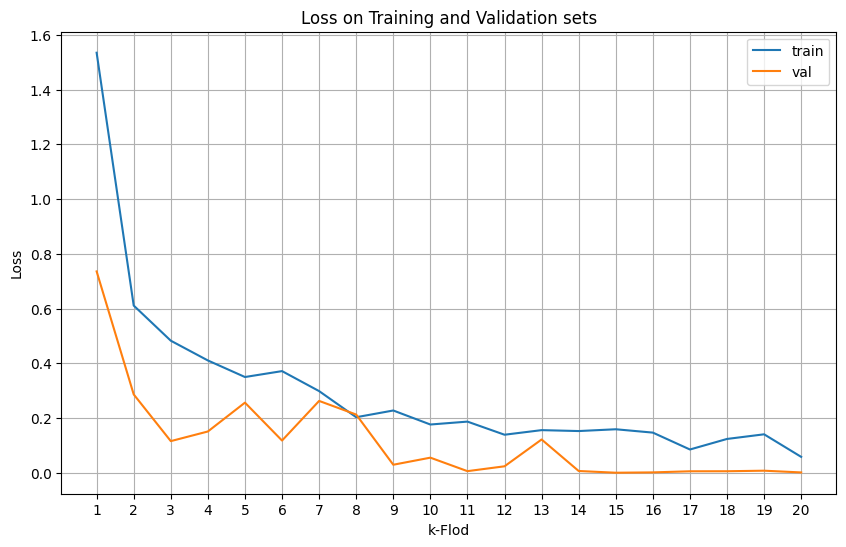

In [4]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_ls) + 1, 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss_ls, label='train')
plt.plot(epochs, test_loss_ls, label='val')
plt.xticks(epochs)
plt.title('Loss on Training and Validation sets')
plt.xlabel('k-Flod')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
model = torch.load('model.pt')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):